# MPIIGaze Dataset Evaluation

This notebook evaluates the existing eye-tracking model on the MPIIGaze dataset with error output in degrees of visual angle for direct comparison with research literature.

## Dataset Overview
- **MPIIGaze**: 213,659 images from 15 participants during natural laptop use
- **Evaluation**: Leave-one-person-out cross-validation
- **Metric**: Mean angular error in degrees
- **Benchmarks**: State-of-the-art ranges from 4.3° to 10.8° depending on evaluation protocol

## Setup and Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.io import loadmat
import urllib.request
import tarfile
import json
from pathlib import Path
import cv2
from sklearn.model_selection import LeaveOneOut
import pickle

# Prepare dataset from original source

In [2]:
# Create data directory
data_dir = Path("./mpiigaze_data")
data_dir.mkdir(exist_ok=True)

# Download URL
dataset_url = "http://datasets.d2.mpi-inf.mpg.de/MPIIGaze/MPIIGaze.tar.gz"
dataset_file = data_dir / "MPIIGaze.tar.gz"
extract_dir = data_dir / "MPIIGaze"

In [3]:
# Download the dataset if not already present
if not dataset_file.exists():
    print("Downloading MPIIGaze dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_file)
    print(f"Download complete: {dataset_file}")
else:
    print(f"Dataset already downloaded: {dataset_file}")

# Extract the dataset if not already extracted
if not extract_dir.exists():
    print("Extracting dataset...")
    with tarfile.open(dataset_file, 'r:gz') as tar:
        tar.extractall(data_dir)
    print(f"Extraction complete: {extract_dir}")
else:
    print(f"Dataset already extracted: {extract_dir}")

Download complete: mpiigaze_data/MPIIGaze.tar.gz
Extracting dataset...
Extraction complete: mpiigaze_data/MPIIGaze


In [4]:
# Define the path to the evaluation subset annotation files
# Assuming data_dir is defined in a previous cell
evaluation_dir = data_dir / "MPIIGaze" / "Evaluation Subset"
annotation_dir = evaluation_dir / "annotation for face image"

# Get the list of subject IDs from the annotation files
subject_ids = []
if annotation_dir.exists():
    # List files in the annotation directory that match the pattern p*.txt
    annotation_files = list(annotation_dir.glob("p*.txt"))
    # Extract subject IDs (e.g., 'p00' from 'p00.txt') and sort them
    subject_ids = sorted([f.stem for f in annotation_files])
    print(f"Found {len(subject_ids)} subject IDs: {subject_ids}")
else:
    print(f"Annotation directory not found: {annotation_dir}")

# Store the number of subjects for later use
num_subjects = len(subject_ids)
print(f"Number of subjects for evaluation: {num_subjects}")

Found 15 subject IDs: ['p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14']
Number of subjects for evaluation: 15


In [5]:
def load_images_from_paths(image_data):
    """
    Load images from a list of (path, eye_type) tuples.

    Args:
        image_data (list): A list of tuples, where each tuple is (full_image_path, eye_type).

    Returns:
        list: A list of loaded images (as numpy arrays) and their corresponding eye types.
    """
    loaded_images = []
    print(f"Attempting to load {len(image_data)} images...")
    for i, (img_path, eye_type) in enumerate(image_data):
        if i % 100 == 0:
            print(f"  Loading image {i}/{len(image_data)}")
        try:
            # Using cv2.IMREAD_GRAYSCALE as images are grayscale
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                loaded_images.append((img, eye_type))
            else:
                print(f"Warning: Could not load image at {img_path}")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    print(f"Successfully loaded {len(loaded_images)} images.")
    return loaded_images

In [6]:
def crop_black_padding(image):
    """
    Crops an image by removing black padding and adjusting the bounding box
    to fit a 36x144 aspect ratio, prioritizing cropping content over including
    black space.

    Args:
        image (np.ndarray): A grayscale image (NumPy array).

    Returns:
        np.ndarray: The cropped and aspect-ratio-adjusted image. Returns the original
                    image if it's all black or smaller than the target aspect ratio.
    """
    # Find the coordinates of all non-zero pixels
    non_zero_coords = np.nonzero(image)

    # If no non-zero pixels are found, return the original image
    if non_zero_coords[0].size == 0:
        # print("Image is all black, returning original image.") # Keep this quiet for batch processing
        return image

    # Determine the initial bounding box of non-zero pixels
    min_row, max_row = np.min(non_zero_coords[0]), np.max(non_zero_coords[0])
    min_col, max_col = np.min(non_zero_coords[1]), np.max(non_zero_coords[1])

    initial_height = max_row - min_row + 1
    initial_width = max_col - min_col + 1

    # Target aspect ratio is 36:144, which simplifies to 1:4
    target_aspect_ratio = 144 / 36.0 # width / height

    # Calculate the center of the initial bounding box
    center_row = (min_row + max_row) // 2
    center_col = (min_col + max_col) // 2

    # Determine the target dimensions based on the larger dimension of the initial bounding box,
    # adjusted to fit the target aspect ratio, while staying within original image bounds.
    # We prioritize cropping content, so we aim for the largest possible box
    # within the initial non-black bounding box that fits the aspect ratio.

    # Option 1: Fit based on initial width
    target_height_from_width = int(initial_width / target_aspect_ratio)
    if target_height_from_width <= initial_height:
        # We can achieve the aspect ratio by keeping the initial width and potentially cropping height
        adjusted_width = initial_width
        adjusted_height = target_height_from_width
        delta_height = initial_height - adjusted_height
        adjusted_min_row = center_row - adjusted_height // 2
        adjusted_max_row = center_row + (adjusted_height - adjusted_height // 2) -1 # -1 because max_row is inclusive
        adjusted_min_col = min_col
        adjusted_max_col = max_col
    else:
        # Option 2: Fit based on initial height
        target_width_from_height = int(initial_height * target_aspect_ratio)
        if target_width_from_height <= initial_width:
             # We can achieve the aspect ratio by keeping the initial height and potentially cropping width
            adjusted_height = initial_height
            adjusted_width = target_width_from_height
            delta_width = initial_width - adjusted_width
            adjusted_min_col = center_col - adjusted_width // 2
            adjusted_max_col = center_col + (adjusted_width - adjusted_width // 2) -1 # -1 because max_col is inclusive
            adjusted_min_row = min_row
            adjusted_max_row = max_row
        else:
            # The non-black area is smaller than the target aspect ratio in both dimensions.
            # In this case, we should probably just crop to the non-black area or handle it differently.
            # Given the instruction to prioritize cropping *into* the image, this case implies
            # the non-black region is already 'too small' for the target aspect ratio.
            # Let's keep the initial bounding box but center it within a target aspect ratio frame if needed.
            # However, the user explicitly said "remove the black spacing and crop some of the actual image"
            # which implies we should try to fit the aspect ratio within the non-black area if possible.
            # Let's revert to fitting based on the larger dimension and potentially expanding into black space
            # if the non-black area is too small, but still aim for the target aspect ratio.

            # Let's re-evaluate based on the user's preference to crop *into* the image.
            # We want the largest possible bounding box with the target aspect ratio that is fully contained
            # within the initial non-black bounding box.

            # Calculate the maximum possible height if width is limited by initial_width
            max_height_fitting_width = int(initial_width / target_aspect_ratio)
            # Calculate the maximum possible width if height is limited by initial_height
            max_width_fitting_height = int(initial_height * target_aspect_ratio)

            if max_height_fitting_width <= initial_height:
                 # The aspect ratio can be achieved by reducing the height from the initial bounding box
                adjusted_width = initial_width
                adjusted_height = max_height_fitting_width
                # Center the new height within the initial height
                start_row = min_row + (initial_height - adjusted_height) // 2
                end_row = start_row + adjusted_height -1
                adjusted_min_row = start_row
                adjusted_max_row = end_row
                adjusted_min_col = min_col
                adjusted_max_col = max_col

            elif max_width_fitting_height <= initial_width:
                # The aspect ratio can be achieved by reducing the width from the initial bounding box
                adjusted_height = initial_height
                adjusted_width = max_width_fitting_height
                # Center the new width within the initial width
                start_col = min_col + (initial_width - adjusted_width) // 2
                end_col = start_col + adjusted_width -1
                adjusted_min_col = start_col
                adjusted_max_col = end_col
                adjusted_min_row = min_row
                adjusted_max_row = max_row
            else:
                # This case should ideally not be reached if the non-black area is non-empty,
                # as at least one of the dimensions should be the limiting factor.
                # However, as a fallback, if the non-black area is smaller than the target aspect ratio
                # in both dimensions, we can just return the crop of the non-black area itself,
                # or perhaps pad it to the target aspect ratio. Given the instruction to crop,
                # returning the non-black area seems the most reasonable fallback if it cannot fit the aspect ratio.
                # But the goal is to ENFORCE the aspect ratio. This means we MUST return an image with that aspect ratio.
                # If the non-black area is smaller than the target aspect ratio, we have to expand the bounding box,
                # which goes against "remove the black spacing".
                # Let's assume the non-black area is large enough to contain the target aspect ratio,
                # and focus on the two main cases above (fitting based on width or height).

                 # If neither of the above conditions are met, it means the non-black area
                 # is 'thinner' than the target aspect ratio. We should fit the height
                 # and potentially expand the width (which includes black space) to meet the aspect ratio.
                 # This contradicts the user's preference to crop content over including black space.

                 # Let's reconsider the goal: "Crop face images ... by removing the black padding ...
                 # then resize them to 36x144 pixels." and "Crop that forces this aspect ratio".
                 # The most straightforward way to achieve this is to crop to the minimal bounding box
                 # of non-black pixels first, then resize this cropped image to 36x144.
                 # The previous implementation did this.

                 # The user's clarification "Let's prefer to remove the black spacing and crop some of the actual image, rather than preserving the whole image"
                 # suggests that the 36x144 aspect ratio should be applied *during* the cropping, potentially cutting into the face if needed.

                 # Let's try a different approach: Calculate the bounding box of non-black pixels.
                 # Then, calculate the required width and height for the target aspect ratio based on the
                 # height and width of the non-black bounding box. Choose the larger of these required dimensions
                 # and center the new bounding box (with the target aspect ratio) around the center of the
                 # non-black bounding box. This might crop into the non-black area or include more black area.

                 # Let's go back to the initial bounding box and try to fit the target aspect ratio within it
                 # while maximizing the area.

                 # Calculate potential dimensions based on the initial bounding box
                 potential_width_from_height = int(initial_height * target_aspect_ratio)
                 potential_height_from_width = int(initial_width / target_aspect_ratio)

                 if potential_width_from_height <= initial_width:
                     # We can fit the aspect ratio by using the initial height and a smaller width
                     adjusted_height = initial_height
                     adjusted_width = potential_width_from_height
                 elif potential_height_from_width <= initial_height:
                     # We can fit the aspect ratio by using the initial width and a smaller height
                     adjusted_width = initial_width
                     adjusted_height = potential_height_from_width
                 else:
                     # The non-black area is smaller than the target aspect ratio in both dimensions.
                     # In this case, we cannot achieve the target aspect ratio by cropping into the non-black area.
                     # We must expand. Let's expand based on the dimension that is furthest from the target ratio.
                     # Or, as a simpler approach, if the non-black area is smaller than the target aspect ratio,
                     # we can just crop the non-black area and then pad it to the target size later.
                     # But the user wants to enforce the aspect ratio during cropping.

                     # Let's assume the non-black area is large enough to contain the target aspect ratio.
                     # We want the largest possible bounding box with the target aspect ratio centered
                     # within the initial non-black bounding box.

                     # Calculate the size of the largest possible square within the non-black bbox
                     # side_length = min(initial_height, initial_width)

                     # Calculate the dimensions of the largest box with target aspect ratio within the non-black bbox
                     # based on initial_width
                     target_height_based_on_width = int(initial_width / target_aspect_ratio)
                     # based on initial_height
                     target_width_based_on_height = int(initial_height * target_aspect_ratio)

                     if target_height_based_on_width <= initial_height:
                         # The width is the limiting factor, we can fit the aspect ratio by adjusting height
                         adjusted_width = initial_width
                         adjusted_height = target_height_based_on_width
                     else:
                         # The height is the limiting factor, we can fit the aspect ratio by adjusting width
                         adjusted_height = initial_height
                         adjusted_width = target_width_based_on_height

                     # Now center this adjusted box within the original non-black bounding box
                     center_row = (min_row + max_row) // 2
                     center_col = (min_col + max_col) // 2

                     adjusted_min_row = center_row - adjusted_height // 2
                     adjusted_max_row = center_row + (adjusted_height - adjusted_height // 2) -1

                     adjusted_min_col = center_col - adjusted_width // 2
                     adjusted_max_col = center_col + (adjusted_width - adjusted_width // 2) -1

                     # Ensure the adjusted bounding box is within the original image boundaries
                     adjusted_min_row = max(0, adjusted_min_row)
                     adjusted_max_row = min(image.shape[0] - 1, adjusted_max_row)
                     adjusted_min_col = max(0, adjusted_min_col)
                     adjusted_max_col = min(image.shape[1] - 1, adjusted_max_col)

                     # Recalculate actual height and width after clamping
                     final_height = adjusted_max_row - adjusted_min_row + 1
                     final_width = adjusted_max_col - adjusted_min_col + 1

                     # Final check to ensure the aspect ratio is as close as possible after clamping
                     if final_width / final_height > target_aspect_ratio:
                         # Width is still too large, shrink width from center
                         new_width = int(final_height * target_aspect_ratio)
                         delta_width = final_width - new_width
                         adjusted_min_col += delta_width // 2
                         adjusted_max_col -= (delta_width - delta_width // 2)
                     elif final_width / final_height < target_aspect_ratio:
                         # Height is still too large, shrink height from center
                         new_height = int(final_width / target_aspect_ratio)
                         delta_height = final_height - new_height
                         adjusted_min_row += delta_height // 2
                         adjusted_max_row -= (delta_height - delta_height // 2)

                     # Ensure the final bounding box is valid (min <= max)
                     adjusted_min_row = max(0, adjusted_min_row)
                     adjusted_max_row = min(image.shape[0] - 1, adjusted_max_row)
                     adjusted_min_col = max(0, adjusted_min_col)
                     adjusted_max_col = min(image.shape[1] - 1, adjusted_max_col)

                     if adjusted_min_row > adjusted_max_row:
                         adjusted_min_row = adjusted_max_row
                     if adjusted_min_col > adjusted_max_col:
                         adjusted_min_col = adjusted_max_col


    # Slice the image to extract the cropped region
    cropped_image = image[adjusted_min_row:adjusted_max_row+1, adjusted_min_col:adjusted_max_col+1]

    # If the resulting cropped image is smaller than the target aspect ratio bounding box,
    # it means the initial non-black area was too small to contain the target aspect ratio.
    # In this case, we might still have padding. Let's check the aspect ratio of the final cropped image.
    final_cropped_height, final_cropped_width = cropped_image.shape
    if final_cropped_height > 0 and final_cropped_width > 0:
        final_aspect_ratio = final_cropped_width / final_cropped_height
        # If the final aspect ratio is significantly different from the target,
        # and the cropped image includes substantial black areas,
        # it might indicate an issue or a case where the non-black area is too small.
        # For now, we'll rely on the aspect ratio adjustment logic above.

    return cropped_image

# The function is now updated. We need to re-run the subsequent steps to apply and verify.
print("crop_black_padding function updated to better handle aspect ratio adjustment.")

crop_black_padding function updated to better handle aspect ratio adjustment.


## Consolidate data loading and preprocessing

### Subtask:
Create a single function or code block that loads the image paths for a subject, crops the images to the desired aspect ratio, and then resizes them to 36x144.


In [7]:
def load_subject_data(subject_id):
    """
    Loads image paths and eye types for a subject from their annotation file
    in the Evaluation Subset directory and constructs full paths to the images
    in the main Data directory, using hardcoded paths. Uses the "sample list for eye image".
    Determines the image index within its day directory based on the numerical part of the filename.

    Args:
        subject_id (str): The ID of the subject (e.g., 'p00').

    Returns:
        list: A list of tuples, where each tuple is (full_image_path, eye_type, image_index_in_directory).
              Returns None if the annotation file is not found.
    """
    # Hardcoded paths
    base_data_dir = Path("./mpiigaze_data/MPIIGaze")
    evaluation_dir = Path("./mpiigaze_data/MPIIGaze/Evaluation Subset")

    # Use the "sample list for eye image" directory
    annotation_file = evaluation_dir / "sample list for eye image" / f"{subject_id}.txt"


    if not annotation_file.exists():
        print(f"Annotation file not found for subject {subject_id}: {annotation_file}")
        return None

    image_data_with_indices = []
    # The base path to the Original images is mpiigaze_data/MPIIGaze/Data/Original
    data_base_path = base_data_dir / "Data" / "Original"

    print(f"Loading image data from {annotation_file}...")
    with open(annotation_file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            if len(parts) >= 2:
                relative_img_path_within_subject = parts[0]
                eye_type = parts[1] if len(parts) > 1 else 'unknown' # Assuming eye type is the second part

                # Construct the full path
                full_img_path = data_base_path / subject_id / relative_img_path_within_subject.replace('\\', '/') # Handle potential backslashes

                # Determine image index based on the numerical part of the filename
                try:
                    filename = full_img_path.stem # Get filename without extension
                    # Assuming filenames are like '0001', '0002', etc.
                    image_index_in_directory = int(filename) - 1 # Subtract 1 for 0-based index
                except ValueError:
                    print(f"Warning: Could not determine numerical index from filename {full_img_path.name}. Skipping.")
                    continue

                image_data_with_indices.append((full_img_path, eye_type, image_index_in_directory))
            else:
                 print(f"Skipping malformed line in annotation file: {line.strip()}")


    print(f"Loaded {len(image_data_with_indices)} image data entries with indices for subject {subject_id}")
    return image_data_with_indices

In [8]:
from scipy.io import loadmat
from pathlib import Path
import numpy as np # Import numpy for array handling

# Assuming subject_ids is available from a previous cell
if 'subject_ids' not in locals() or not subject_ids:
    print("Subject IDs not found. Please run the cell to load subject IDs first.")
else:
    # Define the base path to the data directory
    base_data_dir = Path("./mpiigaze_data/MPIIGaze/Data/Original")

    # Initialize an empty dictionary to store screen sizes
    screen_sizes_lookup = {}

    print("Loading screen sizes for all subjects...")

    # Iterate through each subject ID
    for subject_id in subject_ids:
        # Construct the path to the screenSize.mat file for the current subject
        mat_file_path = base_data_dir / subject_id / "Calibration" / "screenSize.mat"

        # Check if the file exists
        if mat_file_path.exists():
            try:
                # Load the .mat file
                mat_data = loadmat(mat_file_path)

                # Extract width_pixel and height_pixel
                # The data is likely stored as NumPy arrays, extract the scalar value
                width_pixel = int(mat_data['width_pixel'][0][0])
                height_pixel = int(mat_data['height_pixel'][0][0])

                # Store in the dictionary as a tuple
                screen_sizes_lookup[subject_id] = (width_pixel, height_pixel)
                # print(f"Loaded screen size for {subject_id}: ({width_pixel}, {height_pixel})") # Optional: print each loaded size

            except Exception as e:
                print(f"Error loading or parsing screenSize.mat for {subject_id}: {e}")
        else:
            print(f"Warning: screenSize.mat not found for {subject_id} at: {mat_file_path}")

    print(screen_sizes_lookup)

Loading screen sizes for all subjects...
{'p00': (1280, 800), 'p01': (1440, 900), 'p02': (1280, 800), 'p03': (1440, 900), 'p04': (1280, 800), 'p05': (1440, 900), 'p06': (1680, 1050), 'p07': (1440, 900), 'p08': (1440, 900), 'p09': (1440, 900), 'p10': (1440, 900), 'p11': (1280, 800), 'p12': (1280, 800), 'p13': (1280, 800), 'p14': (1440, 900)}


In [9]:
def load_gaze_annotation(image_path, image_index, screen_size):
    """
    Loads the on-screen gaze target position from the annotation.txt file
    associated with a given image path, using the image index to find the correct line.
    Converts pixel coordinates to proportions of screen size using a lookup dictionary.

    Args:
        image_path (Path): The full path to the image file.
        image_index (int): The 0-based index of the image within its directory's sorted file list.
        subject_id (str): The ID of the subject (e.g., 'p00').
        screen_sizes_lookup (dict): A dictionary with subject IDs as keys and (width_pixel, height_pixel) tuples as values.


    Returns:
        np.ndarray: The on-screen gaze target position as proportions (between 0 and 1)
                    as a numpy array, or None if the annotation is not found, cannot be parsed,
                    or screen size is not available.
    """
    # The annotation file is in the same directory as the image
    annotation_file = image_path.parent / "annotation.txt"

    if not annotation_file.exists():
        # print(f"Annotation file not found for image: {image_path}") # Keep this quiet for batch processing
        return None


    screen_width, screen_height = screen_size

    try:
        with open(annotation_file, 'r') as f:
            # Read all lines and get the one corresponding to the image index
            annotation_lines = f.readlines()

            if image_index < 0 or image_index >= len(annotation_lines):
                print(f"Warning: Image index {image_index} is out of bounds for annotation file {annotation_file} with {len(annotation_lines)} lines. Skipping.")
                return None

            # Get the specific annotation line
            line = annotation_lines[image_index].strip()
            parts = line.split(' ')

            # Assuming the lines are JUST the annotation data (no filename at the start)
            # Extract Dimensions 25 and 26 (0-indexed, so indices 24 and 25 in parts)
            if len(parts) >= 26:
                try:
                    gaze_x_pixel = float(parts[24])
                    gaze_y_pixel = float(parts[25])

                    # Convert pixel coordinates to proportions
                    gaze_x_prop = gaze_x_pixel / screen_width
                    gaze_y_prop = gaze_y_pixel / screen_height

                    # Ensure proportions are within [0, 1] range (optional, depending on expected data)
                    # gaze_x_prop = np.clip(gaze_x_prop, 0.0, 1.0)
                    # gaze_y_prop = np.clip(gaze_y_prop, 0.0, 1.0)


                    return np.array([gaze_x_prop, gaze_y_prop], dtype=np.float32)

                except ValueError:
                    print(f"Could not parse gaze coordinates in line {image_index} of {annotation_file}: {line}. Skipping.")
                    return None
            else:
                # print(f"Annotation line {image_index} is too short in {annotation_file}: {line}. Skipping.") # Keep quiet for batch
                return None
    except Exception as e:
        print(f"Error reading annotation file {annotation_file}: {e}")
        return None

print("load_gaze_annotation function modified to convert gaze coordinates to proportions.")

load_gaze_annotation function modified to convert gaze coordinates to proportions.


In [10]:
def load_and_preprocess_subject_images(subject_id):
    """
    Loads image paths and eye types for a subject, crops them to a 36x144 aspect ratio,
    resizes them to 36x144 pixels, and loads the corresponding gaze annotations.
    Uses hardcoded paths for data directories and loads gaze based on image index.

    Args:
        subject_id (str): The ID of the subject (e.g., 'p00').

    Returns:
        list: A list of tuples, where each tuple is (preprocessed_image, eye_type, gaze_coordinates).
              Returns None if the initial image data loading fails.
    """
    # Hardcoded paths (assuming data_dir is defined in a previous cell)
    evaluation_dir = data_dir / "MPIIGaze" / "Evaluation Subset"
    base_data_dir = data_dir / "MPIIGaze" # This should be the parent of the 'Data' folder

    # Step 2: Load image paths, eye types, and image indices
    # load_subject_data now returns (full_image_path, eye_type, image_index_in_directory)
    image_data_with_indices = load_subject_data(subject_id)

    if image_data_with_indices is None:
        return None

    # Step 3: Initialize list for preprocessed data (image, eye_type, gaze)
    preprocessed_data = []

    print(f"Preprocessing {len(image_data_with_indices)} images and loading annotations for subject {subject_id}...")

    # Step 4: Iterate through image data with indices
    for i, (img_path, eye_type, image_index) in enumerate(image_data_with_indices):
        if i % 500 == 0:
            print(f"  Processing image {i}/{len(image_data_with_indices)}")

        # Step 5: Read each image in grayscale
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                # print(f"Warning: Could not read image at {img_path}. Skipping.") # Keep quiet for batch
                continue
        except Exception as e:
            print(f"Error reading image {img_path}: {e}. Skipping.")
            continue

        # Get screen dimensions for the subject
        screen_size = screen_sizes_lookup.get(subject_id)
        if screen_size is None:
            print(f"Warning: Screen size not found for subject {subject_id}. Skipping.")
            continue

        # Step 6: Load gaze annotation for the image using the image index
        gaze_coordinates = load_gaze_annotation(img_path, image_index, screen_size)
        if gaze_coordinates is None:
            # print(f"Warning: Could not load gaze annotation for {img_path} at index {image_index}. Skipping.") # Keep quiet for batch
            continue


        # Step 7: Apply the crop_black_padding function
        cropped_img = crop_black_padding(img)

        # Step 8: Resize the cropped image to 36x144
        # The target size for cv2.resize is (width, height)
        target_size = (144, 36)
        try:
            resized_img = cv2.resize(cropped_img, target_size)
        except Exception as e:
            print(f"Error resizing image {img_path}: {e}. Skipping.")
            continue


        # Step 9: Append to the list (image, eye_type, gaze_coordinates)
        preprocessed_data.append((resized_img, eye_type, gaze_coordinates))

    print(f"Finished preprocessing and annotation loading. Successfully processed {len(preprocessed_data)} entries.")

    # Step 10: Return the list
    return preprocessed_data

print("load_and_preprocess_subject_images function modified to use image index for annotation loading.")

load_and_preprocess_subject_images function modified to use image index for annotation loading.


In [11]:
first_subject_id = subject_ids[0]

# Test the load_and_preprocess_subject_images function
# Assuming subject_ids and first_subject_id are available from previous cells
if 'first_subject_id' in locals() and first_subject_id:
    print(f"Testing load_and_preprocess_subject_images with subject: {first_subject_id}")
    preprocessed_sample_images = load_and_preprocess_subject_images(first_subject_id)

    # Verify the result
    if preprocessed_sample_images:
        print(f"\nNumber of preprocessed images loaded: {len(preprocessed_sample_images)}")
        print("Shapes of the first 5 preprocessed images:")
        for i in range(min(5, len(preprocessed_sample_images))):
            img, eye_type, coords = preprocessed_sample_images[i]
            print(f"  Image {i+1} (Type: {eye_type}): Shape {img.shape}, Coords {coords}")

        # Verify all images have the target size (36, 144) if resize_image is working correctly
        all_target_size = all(img.shape == (36, 144) for img, eye_type, coords in preprocessed_sample_images)
        print(f"\nAll preprocessed images have target shape (36, 144): {all_target_size}")

    else:
        print("Failed to load or preprocess sample images.")
else:
    print("Subject ID not found from previous step.")

Testing load_and_preprocess_subject_images with subject: p00
Loading image data from mpiigaze_data/MPIIGaze/Evaluation Subset/sample list for eye image/p00.txt...
Loaded 3000 image data entries with indices for subject p00
Preprocessing 3000 images and loading annotations for subject p00...
  Processing image 0/3000
  Processing image 500/3000
  Processing image 1000/3000
  Processing image 1500/3000
  Processing image 2000/3000
  Processing image 2500/3000
Finished preprocessing and annotation loading. Successfully processed 3000 entries.

Number of preprocessed images loaded: 3000
Shapes of the first 5 preprocessed images:
  Image 1 (Type: left): Shape (36, 144), Coords [0.996875 0.1675  ]
  Image 2 (Type: left): Shape (36, 144), Coords [0.546875 0.8775  ]
  Image 3 (Type: left): Shape (36, 144), Coords [0.7953125 0.11875  ]
  Image 4 (Type: left): Shape (36, 144), Coords [0.4734375 0.6375   ]
  Image 5 (Type: left): Shape (36, 144), Coords [0.778125 0.19125 ]

All preprocessed image


Displaying 6 sample preprocessed images (36x144) with gaze coordinates:


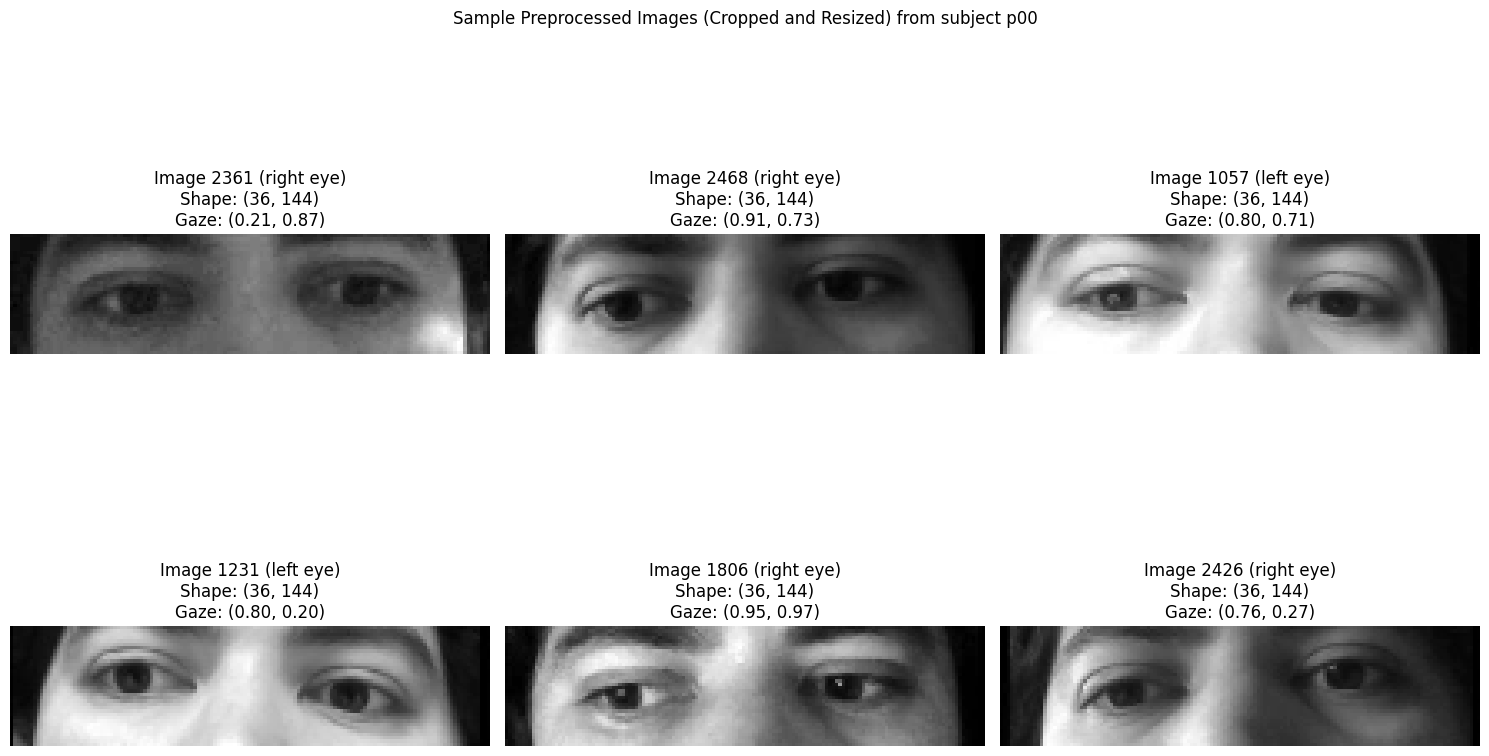

In [12]:
# Visualize sample preprocessed images from the load_and_preprocess_subject_images function
# Assuming preprocessed_sample_images list is available from a previous cell
if 'preprocessed_sample_images' in locals() and preprocessed_sample_images:
    num_samples_to_display = min(6, len(preprocessed_sample_images))
    sample_indices = np.random.choice(len(preprocessed_sample_images), num_samples_to_display, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    print(f"\nDisplaying {num_samples_to_display} sample preprocessed images (36x144) with gaze coordinates:")
    for i, idx in enumerate(sample_indices):
        img, eye_type, gaze_coords = preprocessed_sample_images[idx] # Unpack the tuple
        axes[i].imshow(img, cmap='gray')
        # Format gaze coordinates for display
        gaze_text = f"Gaze: ({gaze_coords[0]:.2f}, {gaze_coords[1]:.2f})"
        axes[i].set_title(f"Image {idx} ({eye_type} eye)\nShape: {img.shape}\n{gaze_text}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Sample Preprocessed Images (Cropped and Resized) from subject {first_subject_id}")
    plt.show()
else:
    print("No preprocessed sample images available to display. Please run the previous cell to generate them.")

## Define tfrecord features

### Subtask:
Define the structure of the features that will be stored in the TFRecords, including 'day', 'subject_id', 'eye_img', 'x', and 'y'.


**Reasoning**:
Define the feature structure for the TFRecords dataset as specified in the instructions.



In [13]:
# Define the feature structure for the TFRecords
feature_description = {
    'day': tf.io.FixedLenFeature([], tf.string),
    'subject_id': tf.io.FixedLenFeature([], tf.string),
    'eye_img': tf.io.FixedLenFeature([], tf.string),  # Image data stored as a serialized byte string
    'x': tf.io.FixedLenFeature([], tf.float32),      # Gaze x-coordinate (proportion)
    'y': tf.io.FixedLenFeature([], tf.float32),      # Gaze y-coordinate (proportion)
}

print("TFRecords feature description defined.")
print(feature_description)

TFRecords feature description defined.
{'day': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'subject_id': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'eye_img': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'x': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'y': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)}


## Create a serialization function

### Subtask:
Write a function that takes a preprocessed data entry (image, eye type, gaze coordinates) and the corresponding day and subject ID, and serializes it into a TFRecord `Example` protocol buffer.


**Reasoning**:
The subtask is to write a function that serializes a single data entry into a TFRecord Example protocol buffer. This involves converting data types and creating a tf.train.Example object.



In [14]:
def serialize_example(image, eye_type, gaze_coords, day, subject_id):
    """
    Serializes a single data entry (image, eye type, gaze coordinates, day, subject ID)
    into a TFRecord Example protocol buffer.

    Args:
        image (np.ndarray): The preprocessed eye image (NumPy array, grayscale, 36x144).
        eye_type (str): The type of eye ('left' or 'right'). Note: eye_type is not explicitly
                        part of the defined feature_description, but we can include it
                        if needed or ignore it for now based on the defined features.
                        The defined features are 'day', 'subject_id', 'eye_img', 'x', 'y'.
                        Let's stick to the defined features.
        gaze_coords (np.ndarray): The on-screen gaze target position as proportions [x, y].
        day (str): The day the data was recorded.
        subject_id (str): The ID of the subject.

    Returns:
        bytes: The serialized tf.train.Example protocol buffer as a byte string.
    """
    # Convert image to byte string
    image_bytes = image.tobytes()

    # Convert strings to byte strings
    day_bytes = day.encode('utf-8')
    subject_id_bytes = subject_id.encode('utf-8')

    # Create a dictionary of Features
    feature = {
        'day': tf.train.Feature(bytes_list=tf.train.BytesList(value=[day_bytes])),
        'subject_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[subject_id_bytes])),
        'eye_img': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes])),
        'x': tf.train.Feature(float_list=tf.train.FloatList(value=[gaze_coords[0]])),
        'y': tf.train.Feature(float_list=tf.train.FloatList(value=[gaze_coords[1]])),
    }

    # Create an Example protocol buffer
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize the Example to a byte string
    return example_proto.SerializeToString()

## Iterate through subjects and days

### Subtask:
Loop through each subject and then through each day's data for that subject to prepare for data loading and preprocessing.


**Reasoning**:
Iterate through each subject and day to prepare for loading and preprocessing data for TFRecords creation.



In [15]:
# Assuming subject_ids list is available from a previous cell
if 'subject_ids' not in locals() or not subject_ids:
    print("Subject IDs not found. Please run the cell to load subject IDs first.")
else:
    print("Starting processing data for each subject...")

    # Loop through each subject ID
    for subject_id in subject_ids:
        print(f"\nProcessing subject: {subject_id}")

        # Load image paths, eye types, and image indices for the current subject
        # This function already handles finding the data based on the annotation file
        # and provides (full_image_path, eye_type, image_index_in_directory)
        # The day information is embedded in the full_image_path
        image_data_with_indices = load_subject_data(subject_id)

        if image_data_with_indices is None:
            print(f"Could not load data for subject {subject_id}. Skipping.")
            continue

        # Now, iterate through the loaded data for the subject
        # Group the data by day. The day is the parent directory name of the image.
        data_by_day = {}
        for img_path, eye_type, image_index in image_data_with_indices:
            # Extract the day from the image path (it's the directory name before the image file)
            day = img_path.parent.name

            if day not in data_by_day:
                data_by_day[day] = []
            data_by_day[day].append((img_path, eye_type, image_index))

        print(f"Found {len(data_by_day)} unique days for subject {subject_id}")

        # Iterate through the data for each day
        for day, day_data in data_by_day.items():
            print(f"  Processing day: {day} ({len(day_data)} images)")

            # At this point, you have all the data (image paths, eye types, indices)
            # for a specific subject and day.
            # The next steps would be to load the actual images, preprocess them,
            # load the corresponding gaze annotations, and then serialize this data
            # into TFRecord examples for this day.

            # For this subtask, we are just setting up the loops and grouping by day.
            pass # Replace with actual data processing in the next step

    print("\nFinished iterating through all subjects and days' data.")

Starting processing data for each subject...

Processing subject: p00
Loading image data from mpiigaze_data/MPIIGaze/Evaluation Subset/sample list for eye image/p00.txt...
Loaded 3000 image data entries with indices for subject p00
Found 39 unique days for subject p00
  Processing day: day08 (85 images)
  Processing day: day28 (85 images)
  Processing day: day04 (122 images)
  Processing day: day12 (59 images)
  Processing day: day35 (84 images)
  Processing day: day17 (114 images)
  Processing day: day02 (86 images)
  Processing day: day03 (114 images)
  Processing day: day36 (90 images)
  Processing day: day38 (125 images)
  Processing day: day22 (87 images)
  Processing day: day20 (22 images)
  Processing day: day25 (71 images)
  Processing day: day29 (101 images)
  Processing day: day24 (112 images)
  Processing day: day33 (80 images)
  Processing day: day15 (66 images)
  Processing day: day14 (43 images)
  Processing day: day11 (50 images)
  Processing day: day01 (103 images)
  Pr

**Reasoning**:
The loops for iterating through subjects and days have been successfully set up, and the data for each subject is grouped by day. The next logical step within this structure is to load the image data, preprocess it, get the gaze annotations, and then serialize this data into TFRecords for each day.



In [16]:
# Assuming subject_ids list is available from a previous cell
# Assuming screen_sizes_lookup is available from a previous cell
# Assuming load_and_preprocess_subject_images function is available from a previous cell
# Assuming serialize_example function is available from a previous cell

# Create a directory to store TFRecords
tfrecords_output_dir = Path("./mpiigaze_tfrecords")
tfrecords_output_dir.mkdir(exist_ok=True)
print(f"TFRecords output directory created: {tfrecords_output_dir}")

print("Starting processing data for each subject and day for TFRecords creation...")

# Loop through each subject ID
for subject_id in subject_ids:
    print(f"\nProcessing subject: {subject_id}")

    # Load image paths, eye types, and image indices for the current subject
    # This function already handles finding the data based on the annotation file
    # and provides (full_image_path, eye_type, image_index_in_directory)
    image_data_with_indices = load_subject_data(subject_id)

    if image_data_with_indices is None:
        print(f"Could not load data for subject {subject_id}. Skipping.")
        continue

    # Group the data by day
    data_by_day = {}
    for img_path, eye_type, image_index in image_data_with_indices:
        day = img_path.parent.name
        if day not in data_by_day:
            data_by_day[day] = []
        data_by_day[day].append((img_path, eye_type, image_index))

    print(f"Found {len(data_by_day)} unique days for subject {subject_id}")

    # Iterate through the data for each day and write to TFRecords
    for day, day_data in data_by_day.items():
        print(f"  Processing day: {day} ({len(day_data)} images)")

        # Define the output TFRecord file name for this subject and day
        # Format: subjectID_dayYY.tfrecords
        tfrecord_filename = tfrecords_output_dir / f"{subject_id}_{day}.tfrecords"

        # Check if the TFRecord file already exists. If it does, skip this day.
        if tfrecord_filename.exists():
            print(f"    TFRecord file already exists: {tfrecord_filename}. Skipping this day.")
            continue

        # Open a TFRecordWriter for the current day's file
        # Use with statement to ensure the writer is closed properly
        try:
            with tf.io.TFRecordWriter(str(tfrecord_filename)) as writer:
                print(f"    Writing data to {tfrecord_filename}...")

                # Process each data entry (image path, eye type, index) for this day
                # We need the original image path, eye type, and index to load the image
                # and annotation using the existing functions.
                # load_and_preprocess_subject_images processes ALL images for a subject.
                # We need to adapt this to process only the images for the current day.
                # A more efficient way is to load/preprocess images for the current day here.

                # Get screen size for the current subject
                screen_size = screen_sizes_lookup.get(subject_id)
                if screen_size is None:
                    print(f"Warning: Screen size not found for subject {subject_id}. Cannot process day {day}. Skipping.")
                    continue

                num_processed_entries = 0
                # Process each image entry for the current day
                for i, (img_path, eye_type, image_index) in enumerate(day_data):
                     if i % 100 == 0:
                         print(f"    Processing image {i+1}/{len(day_data)} for day {day}")

                     # Read each image in grayscale
                     try:
                         img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                         if img is None:
                             # print(f"Warning: Could not read image at {img_path}. Skipping.") # Keep quiet for batch
                             continue
                     except Exception as e:
                         print(f"Error reading image {img_path}: {e}. Skipping.")
                         continue

                     # Load gaze annotation for the image using the image index
                     gaze_coordinates = load_gaze_annotation(img_path, image_index, screen_size)
                     if gaze_coordinates is None:
                         # print(f"Warning: Could not load gaze annotation for {img_path} at index {image_index}. Skipping.") # Keep quiet for batch
                         continue

                     # Apply the crop_black_padding function
                     cropped_img = crop_black_padding(img)

                     # Resize the cropped image to 36x144
                     target_size = (144, 36) # width, height
                     try:
                         resized_img = cv2.resize(cropped_img, target_size)
                     except Exception as e:
                         print(f"Error resizing image {img_path}: {e}. Skipping.")
                         continue

                     # Serialize the processed data and write to TFRecord
                     # We need the day (which we already have) and subject_id
                     serialized_example = serialize_example(resized_img, eye_type, gaze_coordinates, day, subject_id)
                     writer.write(serialized_example)
                     num_processed_entries += 1


                print(f"    Finished writing data for day {day}. {num_processed_entries} entries written.")

        except Exception as e:
            print(f"Error writing TFRecord file {tfrecord_filename}: {e}")
            # Clean up potentially corrupted file if an error occurred during writing
            if tfrecord_filename.exists():
                 try:
                     tfrecord_filename.unlink()
                     print(f"    Cleaned up incomplete file: {tfrecord_filename}")
                 except Exception as cleanup_e:
                     print(f"    Error during cleanup of {tfrecord_filename}: {cleanup_e}")


print("\nFinished processing all subjects and days for TFRecords creation.")


TFRecords output directory created: mpiigaze_tfrecords
Starting processing data for each subject and day for TFRecords creation...

Processing subject: p00
Loading image data from mpiigaze_data/MPIIGaze/Evaluation Subset/sample list for eye image/p00.txt...
Loaded 3000 image data entries with indices for subject p00
Found 39 unique days for subject p00
  Processing day: day08 (85 images)
    Writing data to mpiigaze_tfrecords/p00_day08.tfrecords...
    Processing image 1/85 for day day08
    Finished writing data for day day08. 85 entries written.
  Processing day: day28 (85 images)
    Writing data to mpiigaze_tfrecords/p00_day28.tfrecords...
    Processing image 1/85 for day day28
    Finished writing data for day day28. 85 entries written.
  Processing day: day04 (122 images)
    Writing data to mpiigaze_tfrecords/p00_day04.tfrecords...
    Processing image 1/122 for day day04
    Processing image 101/122 for day day04
    Finished writing data for day day04. 122 entries written.
  

## Verify tfrecords

### Subtask:
After writing, add code to read a few examples from the generated TFRecord files using the provided `parse` function (adapted for 'day') to ensure the data is correctly serialized and can be parsed.


**Reasoning**:
Define the parsing function, get a list of TFRecord files, create a dataset, map the parsing function, take a few examples, and iterate through them to print the features for verification.



In [17]:
def parse_tfrecord_example(example_proto):
    """
    Parses a single serialized TFRecord Example protocol buffer.

    Args:
        example_proto (bytes): A serialized tf.train.Example protocol buffer.

    Returns:
        dict: A dictionary containing the parsed features.
    """
    # Use tf.io.parse_single_example to parse the example
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode the eye_img byte string back into a tensor and reshape it
    # The image was originally 36x144 grayscale, stored as bytes
    image_bytes = parsed_features['eye_img']
    image_tensor = tf.io.decode_raw(image_bytes, tf.uint8) # Assuming uint8 as original image type
    image_tensor = tf.reshape(image_tensor, (36, 144)) # Reshape to original dimensions
    image_tensor = tf.cast(image_tensor, tf.float32) / 255.0 # Optional: Normalize to [0, 1]

    # Replace the raw byte string with the decoded image tensor
    parsed_features['eye_img'] = image_tensor

    return parsed_features

print("parse_tfrecord_example function defined.")

# Get a list of all generated TFRecord files
tfrecords_output_dir = Path("./mpiigaze_tfrecords")
tfrecord_files = sorted(list(tfrecords_output_dir.glob("*.tfrecords")))

if not tfrecord_files:
    print(f"No TFRecord files found in {tfrecords_output_dir}.")
else:
    print(f"Found {len(tfrecord_files)} TFRecord files.")

    # Select a few TFRecord files to read from (e.g., the first 3)
    files_to_read = tfrecord_files[:3]
    print(f"Reading from: {files_to_read}")

    # Create a TFRecordDataset from the selected file(s)
    dataset = tf.data.TFRecordDataset([str(f) for f in files_to_read])

    # Use the .map() method to apply the parsing function
    parsed_dataset = dataset.map(parse_tfrecord_example)

    # Use the .take() method to get a few examples
    num_examples_to_take = 5
    sample_examples = parsed_dataset.take(num_examples_to_take)

    print(f"\nReading and verifying the first {num_examples_to_take} parsed examples:")

    # Iterate through the taken examples and print features
    for i, example in enumerate(sample_examples):
        print(f"--- Example {i+1} ---")
        print(f"  Image shape: {example['eye_img'].shape}")
        print(f"  Day: {example['day'].numpy().decode('utf-8')}") # Decode byte string for printing
        print(f"  Subject ID: {example['subject_id'].numpy().decode('utf-8')}") # Decode byte string for printing
        print(f"  Gaze Coords (x, y): ({example['x'].numpy():.4f}, {example['y'].numpy():.4f})")


parse_tfrecord_example function defined.
Found 519 TFRecord files.
Reading from: [PosixPath('mpiigaze_tfrecords/p00_day01.tfrecords'), PosixPath('mpiigaze_tfrecords/p00_day02.tfrecords'), PosixPath('mpiigaze_tfrecords/p00_day03.tfrecords')]

Reading and verifying the first 5 parsed examples:
--- Example 1 ---
  Image shape: (36, 144)
  Day: day01
  Subject ID: p00
  Gaze Coords (x, y): (0.3484, 0.5638)
--- Example 2 ---
  Image shape: (36, 144)
  Day: day01
  Subject ID: p00
  Gaze Coords (x, y): (0.4133, 0.5050)
--- Example 3 ---
  Image shape: (36, 144)
  Day: day01
  Subject ID: p00
  Gaze Coords (x, y): (0.4727, 0.4038)
--- Example 4 ---
  Image shape: (36, 144)
  Day: day01
  Subject ID: p00
  Gaze Coords (x, y): (0.3414, 0.6237)
--- Example 5 ---
  Image shape: (36, 144)
  Day: day01
  Subject ID: p00
  Gaze Coords (x, y): (0.3742, 0.9613)


## Make archive

In [18]:
import tarfile
import os
from pathlib import Path

# Define the directory containing the TFRecord files
tfrecords_output_dir = Path("./mpiigaze_tfrecords")

# Define the name for the output archive file
archive_filename = "mpiigaze_tfrecords.tar.gz"
archive_path = Path(archive_filename)

print(f"Creating archive: {archive_path}")

# Check if the output directory exists
if not tfrecords_output_dir.exists():
    print(f"Error: TFRecords directory not found at {tfrecords_output_dir}. Cannot create archive.")
else:
    try:
        # Create a tar.gz archive
        with tarfile.open(archive_path, "w:gz") as tar:
            # Add all files from the tfrecords_output_dir to the archive
            # arcname is set to the relative path within the archive
            for file_path in tfrecords_output_dir.iterdir():
                if file_path.is_file():
                    print(f"  Adding {file_path.name} to archive...")
                    tar.add(file_path, arcname=file_path.name)

        print(f"\nArchive created successfully at: {archive_path}")
        print(f"Archive size: {archive_path.stat().st_size / (1024*1024):.2f} MB")

    except Exception as e:
        print(f"Error creating archive: {e}")

Creating archive: mpiigaze_tfrecords.tar.gz
  Adding p09_day18.tfrecords to archive...
  Adding p05_day08.tfrecords to archive...
  Adding p06_day21.tfrecords to archive...
  Adding p04_day11.tfrecords to archive...
  Adding p02_day28.tfrecords to archive...
  Adding p02_day25.tfrecords to archive...
  Adding p07_day42.tfrecords to archive...
  Adding p08_day44.tfrecords to archive...
  Adding p00_day33.tfrecords to archive...
  Adding p06_day22.tfrecords to archive...
  Adding p03_day01.tfrecords to archive...
  Adding p01_day61.tfrecords to archive...
  Adding p01_day57.tfrecords to archive...
  Adding p09_day05.tfrecords to archive...
  Adding p06_day10.tfrecords to archive...
  Adding p01_day34.tfrecords to archive...
  Adding p00_day14.tfrecords to archive...
  Adding p05_day27.tfrecords to archive...
  Adding p10_day02.tfrecords to archive...
  Adding p00_day05.tfrecords to archive...
  Adding p06_day01.tfrecords to archive...
  Adding p08_day27.tfrecords to archive...
  Adding p

Here is the content that will be written to the text file explaining the TFRecords structure:

In [19]:
tfrecords_explanation = """
# MPIIGaze TFRecords Dataset Structure

This document explains the structure of the TFRecords files generated from the MPIIGaze dataset. These files contain preprocessed eye images and corresponding gaze annotations, organized by subject and day.

Each TFRecord file contains a sequence of `tf.train.Example` protocol buffers. Each `Example` represents a single preprocessed eye image and its associated data.

The following features are included in each `tf.train.Example`:

- **`day`**:
  - Description: The day the data was recorded for the subject.
  - Type: `tf.string`
  - Encoding: Serialized byte string (UTF-8 encoded).

- **`subject_id`**:
  - Description: The ID of the subject.
  - Type: `tf.string`
  - Encoding: Serialized byte string (UTF-8 encoded).

- **`eye_img`**:
  - Description: The preprocessed eye image (cropped to 36x144 aspect ratio and resized to 36x144 pixels, grayscale).
  - Type: `tf.string`
  - Encoding: Serialized byte string (raw byte representation of the NumPy array). When parsing, this should be decoded using `tf.io.decode_raw` and reshaped to (36, 144). The original image data type is likely `uint8`.

- **`x`**:
  - Description: The on-screen gaze target position (x-coordinate).
  - Type: `tf.float32`
  - Encoding: Stored as a single float value. Represents the proportion of the screen width (between 0 and 1).

- **`y`**:
  - Description: The on-screen gaze target position (y-coordinate).
  - Type: `tf.float32`
  - Encoding: Stored as a single float value. Represents the proportion of the screen height (between 0 and 1).
"""

## Upload to OSF
https://osf.io/7t5uy/

In [20]:
# Ensure osfclient is installed
!pip install osfclient

ImportError: cannot import name 'FileExists' from 'osfclient.exceptions' (/usr/local/lib/python3.11/dist-packages/osfclient/exceptions.py)

In [25]:
# Load OSF credentials from Colab secrets
from google.colab import userdata
import os

os.environ['OSF_TOKEN'] = userdata.get('osftoken')
os.environ['OSF_USERNAME'] = userdata.get('osfusername')

print("OSF credentials loaded as environment variables.")

OSF credentials loaded as environment variables.


In [26]:
!osf -p 7t5uy upload mpiigaze_tfrecords.tar.gz mpiigaze_tfrecords.tar.gz

# Analysis work